In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
import japanize_matplotlib
import gc
from time import time
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from hyperopt import fmin, tpe, hp,Trials,STATUS_OK,space_eval

In [64]:
train=pd.read_feather('train_feat1.ftr')
test=pd.read_feather('test_feat1.ftr')
Y_train=train.rent
X_train=train.drop(['id','rent'],axis=1)

test.index=test['index']
X_test=test.drop(['id','rent','index','level_0'],axis=1)

In [67]:
categorical_features=list(X_train.columns[X_train.dtypes=='category'])

In [83]:
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [94]:
params = {
    'max_bin' : 63,
    'n_estimators' : 10000,
    'learning_rate': 0.01,
    'min_data_in_leaf' : 50,
    'num_leaves' : 100,
    'sparse_threshold' : 1.0,
    'device' : 'cpu',
    'save_binary': True,
    'seed' : 42,
    'feature_fraction_seed': 42,
    'bagging_seed' : 42,
    'drop_seed' : 42,
    'data_random_seed' : 42,
    'objective' : 'regression',
    'boosting_type' : 'gbdt',
    'verbose' : 0,
    'metric' : 'RMSE',
    'is_unbalance' : True,
    'boost_from_average' : False,
}

In [95]:
splits = 5
folds = KFold(n_splits=splits)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

y_preds = np.zeros(X_test.shape[0])

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="rmse",
            early_stopping_rounds=100,
            categorical_feature = categorical_features,
            verbose= 500)
    
    del X_trn, y_trn
    
    val=reg.predict(X_val)
    feature_importances['fold_{}'.format(fold_n + 1)] = reg.feature_importances_
    
    y_preds+=reg.predict(X_test)/splits
    del reg, X_val
    print('RMSE accuracy: {}'.format(rmse(y_val, val)))
    del val,y_val

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 16210.3	valid_1's rmse: 34777
[1000]	training's rmse: 12228.6	valid_1's rmse: 33023.8
[1500]	training's rmse: 10116.3	valid_1's rmse: 32234.5
[2000]	training's rmse: 8741.16	valid_1's rmse: 31738.9
[2500]	training's rmse: 7753.65	valid_1's rmse: 31375.1
[3000]	training's rmse: 6963.39	valid_1's rmse: 31076.3
[3500]	training's rmse: 6322.71	valid_1's rmse: 30860.5
[4000]	training's rmse: 5792.25	valid_1's rmse: 30680.3
[4500]	training's rmse: 5249.98	valid_1's rmse: 30563.1
[5000]	training's rmse: 4790.75	valid_1's rmse: 30426.2
[5500]	training's rmse: 4392.57	valid_1's rmse: 30305.1
[6000]	training's rmse: 4091.44	valid_1's rmse: 30207
[6500]	training's rmse: 3838.9	valid_1's rmse: 30118.3
[7000]	training's rmse: 3618.7	valid_1's rmse: 30034.1
[7500]	training's rmse: 3379.3	valid_1's rmse: 29951.9
[8000]	training's rmse: 3145.23	valid_1's rmse: 29888.4
[8500]	training's rmse: 2936.9

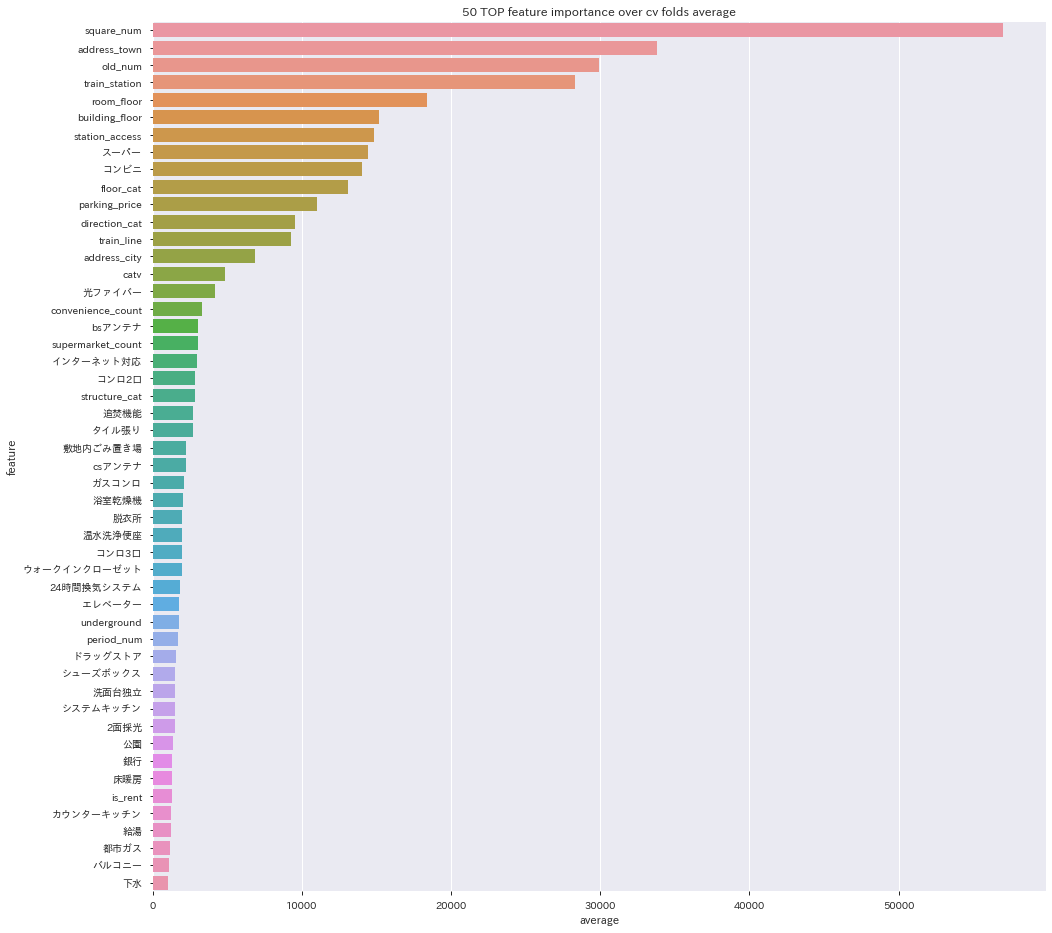

In [98]:
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances.to_feather('feat1_lighgbm_importance.ftr')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');
plt.savefig('feat1_lighgbm_importance.png')

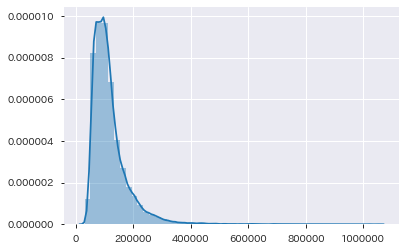

In [100]:
sns.distplot(y_preds)

## Hyperopt

In [89]:
splits=5
folds =KFold(n_splits=splits)

def objective(space):
    print ('='*30 + 'New Run' + '='*30)
    rmse_scores = np.zeros(5)
    ## Do cross validation
    for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
        reg = lgb.LGBMRegressor(n_estimators = 1000,
                                tree_method= 'gpu_hist',
                                max_depth = int(space['max_depth']),
                                min_child_weight = space['min_child_weight'],
                                subsample = space['subsample'],
                                num_leaves = space['num_leaves'],
                                feature_fraction = space['feature_fraction'],
                                max_delta_step = space['max_delta_step'],
                                colsample_bytree = 0.8,
                                importance_type = 'weight'
                               )
    
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
        y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
        eval_set  = [(X_trn,y_trn), (X_val, y_val)]

        reg.fit(X_trn, y_trn,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=100,
            verbose= False)
        
        del X_trn, y_trn, eval_set
        gc.collect()
        
        pred = reg.predict(X_val)
        auc = rmse(y_val, pred)      
        rmse_scores[fold_n] = auc
        print ("Score for fold {}: {}".format(fold_n+1, auc))        
        
        del pred, auc, reg
        gc.collect()
        
    print ("**Average RMSE across all folds: {}".format(rmse_scores.mean()))
    return{'loss':rmse_scores.mean(), 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.8, 1),
        'num_leaves': hp.choice('num_leaves', list(range(20, 100, 10))),
        'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
        'max_delta_step': hp.quniform ('max_delta_step', 1, 10, 1)}

In [90]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

==============================New Run==============================
Score for fold 1: 78411.13342416873                 
Score for fold 2: 72132.22360097383                 
Score for fold 3: 71416.58677371044                 
Score for fold 4: 73421.59945498232                 
Score for fold 5: 72879.29104117435                 
**Average RMSE across all folds: 73652.16685900193  
==============================New Run==============================         
Score for fold 1: 78149.58366776814                                         
Score for fold 2: 71852.77224631737                                         
Score for fold 3: 71136.42136461487                                         
Score for fold 4: 73147.94848075941                                         
Score for fold 5: 72600.37019947097                                         
**Average RMSE across all folds: 73377.41919178615                          
==============================New Run==============================        

Score for fold 2: 71752.46303247438                                          
Score for fold 3: 71035.03215340099                                          
Score for fold 4: 73049.46456499233                                          
Score for fold 5: 72499.20447430591                                          
**Average RMSE across all folds: 73278.35219098382                           
==============================New Run==============================          
Score for fold 1: 78263.16287244433                                          
Score for fold 2: 71974.09907553322                                          
Score for fold 3: 71257.49199734048                                          
Score for fold 4: 73266.3605228069                                           
Score for fold 5: 72720.55067255904                                          
**Average RMSE across all folds: 73496.3330281368                            
==============================New Run===========================

In [36]:
best_params = space_eval(space, best)
print (best_params)

{'feature_fraction': 0.798126399203105, 'max_delta_step': 10.0, 'max_depth': 10.0, 'min_child_weight': 7.0, 'num_leaves': 60, 'subsample': 0.9438934650393279}


In [40]:
best_params={'feature_fraction': 0.798126399203105, 'max_delta_step': 10.0, 'max_depth': 10
            , 'min_child_weight': 7.0, 'num_leaves': 60, 'subsample': 0.9438934650393279}
reg = lgb.LGBMRegressor(**best_params, 
                        n_estimators = 1000,
                        tree_method= 'gpu_hist',
                        colsample_bytree = 0.8)
reg.fit(X_train,Y_train)
prediction_opt= reg.predict(X_test)

In [49]:
sub=pd.read_csv('../input/sample_submit.csv',header=None)
sub[1]=prediction_opt

In [50]:
sub.to_csv('feat1_lighgbm.csv',header=False, index=False)